In [17]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [18]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('.././Dataset/AMZN.csv')
df1=df.reset_index()['Open']

In [19]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [20]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [21]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [22]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [23]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [24]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [25]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 15s 479ms/step - loss: 0.0752 - val_loss: 0.0178
Epoch 2/100
14/14 [==============================] - 4s 261ms/step - loss: 0.0131 - val_loss: 0.0169
Epoch 3/100
14/14 [==============================] - 4s 292ms/step - loss: 0.0043 - val_loss: 0.0147
Epoch 4/100
14/14 [==============================] - 7s 407ms/step - loss: 0.0025 - val_loss: 0.0112
Epoch 5/100
14/14 [==============================] - 4s 286ms/step - loss: 0.0022 - val_loss: 0.0102
Epoch 6/100
14/14 [==============================] - 5s 330ms/step - loss: 0.0021 - val_loss: 0.0099
Epoch 7/100
14/14 [==============================] - 5s 322ms/step - loss: 0.0021 - val_loss: 0.0102
Epoch 8/100
14/14 [==============================] - 3s 243ms/step - loss: 0.0020 - val_loss: 0.0101
Epoch 9/100
14/14 [==============================] - 4s 288ms/step - loss: 0.0020 - val_loss: 0.0098
Epoch 10/100
14/14 [==============================] - 4s 274ms/step - loss: 0.0020 - val_l

In [26]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 38ms/step


In [27]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
yval=yval.reshape(-1,1)
ytest=ytest.reshape(-1,1)
yval=scaler.inverse_transform(yval)
ytest=scaler.inverse_transform(ytest)

In [28]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 2.6635959827454965
Testing RMSE: 7.436745486600266


In [29]:
from sklearn import metrics
valid_mape = round(metrics.mean_absolute_error(y_pred_val,yval),4)
test_mape = round(metrics.mean_absolute_error(y_pred,ytest),4)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAPE: 2.167
Testing MAPE: 5.9018


In [30]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [31]:

from numpy import array

lst_output=[]

n_steps=80
i=0

while(i<30):
    
    if(len(temp_input)>80):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        x_input
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, len(temp_input),1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
# 

[0.5397874]
81
1 day input [0.32722672 0.31644586 0.2976366  0.29580157 0.30360055 0.28379733
 0.28953184 0.28081538 0.28639701 0.26758781 0.27775697 0.29648975
 0.28784971 0.28433254 0.28494424 0.27722174 0.25657751 0.28609116
 0.28142708 0.3007715  0.33166143 0.32110994 0.31904548 0.33670777
 0.33655487 0.31851027 0.32615629 0.31881612 0.32325081 0.34511844
 0.34978252 0.35085295 0.35429364 0.36316305 0.3390016  0.34060726
 0.33938392 0.33632551 0.32523874 0.34909435 0.35742854 0.36346884
 0.34534781 0.36025753 0.37990779 0.39183563 0.37080907 0.37180303
 0.39565864 0.39237084 0.37111486 0.34450674 0.36186318 0.36415701
 0.36591557 0.37180303 0.3751673  0.39519983 0.41760268 0.42624272
 0.41852022 0.41775563 0.44711631 0.46087917 0.47211884 0.46149082
 0.44237577 0.45063348 0.46042037 0.45590925 0.50430857 0.49727419
 0.49146325 0.52380589 0.51187812 0.52495281 0.5397861  0.50920202
 0.51738326 0.53978741]
1 day output [[0.54152143]]
2 day input [0.31644586 0.2976366  0.29580157 0.30

In [32]:
lst_output

[[0.5397874116897583],
 [0.541521430015564],
 [0.5448930859565735],
 [0.5493136644363403],
 [0.5543041229248047],
 [0.5595967769622803],
 [0.5650727152824402],
 [0.5706889033317566],
 [0.5764312148094177],
 [0.5822927951812744],
 [0.5882653594017029],
 [0.5943389534950256],
 [0.6005010604858398],
 [0.6067392230033875],
 [0.6130399703979492],
 [0.619390606880188],
 [0.62577885389328],
 [0.6321927309036255],
 [0.6386207342147827],
 [0.6450529098510742],
 [0.6514788866043091],
 [0.6578897833824158],
 [0.6642769575119019],
 [0.6706326603889465],
 [0.6769500374794006],
 [0.6832218766212463],
 [0.68944251537323],
 [0.6956064105033875],
 [0.701708197593689],
 [0.7077438831329346]]

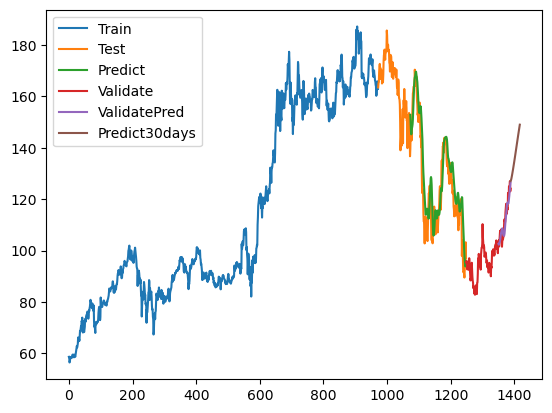

In [33]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [34]:
scaler.inverse_transform(lst_output)

array([[127.01017367],
       [127.23696073],
       [127.67792949],
       [128.25608368],
       [128.90877077],
       [129.60098111],
       [130.31716265],
       [131.05168703],
       [131.80270671],
       [132.56932522],
       [133.35045897],
       [134.14480612],
       [134.9507296 ],
       [135.76660015],
       [136.590656  ],
       [137.42123668],
       [138.25673634],
       [139.09558806],
       [139.93628733],
       [140.77753228],
       [141.61796649],
       [142.45642844],
       [143.29178778],
       [144.12303108],
       [144.94926187],
       [145.76953689],
       [146.58311557],
       [147.38927291],
       [148.18730734],
       [148.97669654]])

In [ ]:
anomalies
data=anomalies[0]
data=np.array(data)
resultarray=[]
count=len(data)
for i in count:
    previous15=data[i]-15
    continue15=data[i]+15
    result=df.iloc[previous15:continue15+1]
    result=result.mean()
    resultarray.append(result)
